In [11]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import os

In [12]:
absolute_path = os.path.join(os.getcwd(), '/mnist')

In [13]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = MNIST(os.getcwd(), transform=transform, download=True)
test_dataset  = MNIST(os.getcwd(), transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

one_image_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) # For visualising

In [14]:
def plot_image(tensor):

    if tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)

    image = tensor.numpy()


    plt.imshow(image, cmap='gray' if tensor.ndim == 2 else None)
    plt.axis('off')
    plt.show()

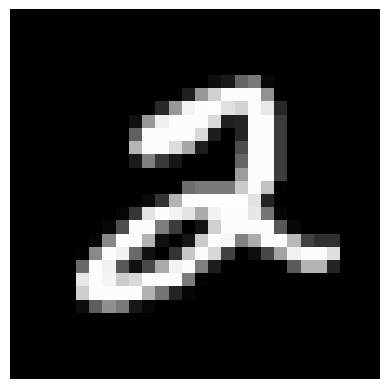

In [15]:
plot_image(train_dataset[5][0])

# Autoencoder:

In [25]:
class AutoEncodingVariationalBayes(nn.Module):
    def __init__(self, input_dim, hidden_layers, inter_dim = 256):
        super(AutoEncodingVariationalBayes, self).__init__()

        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.inter_dim = inter_dim

        # Appendix C.2, switch-out Z with X as described ============================
        self.encoder_mlp = nn.Sequential(
            nn.Linear(self.input_dim, inter_dim), # Here are the weights W_3 that make up phi
            nn.Tanh(),
        )

        self.latent_u_prediction_head = nn.Linear(inter_dim, hidden_layers) # Here are the weights W_4 that make up phi
        self.latent_sigma_prediction_head = nn.Linear(inter_dim, hidden_layers) # Here are the weights W_5 that make up phi
        # ===========================================================================

        # Appendix C.2, implemented exactly in this way ---------------------------------
        self.decoder_mlp = nn.Sequential(
            nn.Linear(hidden_layers, inter_dim), # Here are the weights W_3 that make up theta
            nn.Tanh()
        )

        self.output_u_prediction_head = nn.Linear(inter_dim, input_dim) # Here are the weights W_4 that make up theta
        self.output_sigma_prediction_head = nn.Linear(inter_dim, input_dim) # Here are the weights W_5 that make up theta
        # ---------------------------------------------------------------------------------

    def encoder_forward(self, X):
        h = self.encoder_mlp(X)
        latent_u = self.latent_u_prediction_head(h)
        latent_sigma = self.latent_sigma_prediction_head(h)

        return latent_u, latent_sigma # These are the estimates of parameters for q_phi(Z|X) ~ N(latent_u, latent_sigma)

    def decoder_forward(self, latent_u, latent_sigma, sampled_error_e = 0):
        Z = latent_u + latent_sigma*sampled_error_e # Latent variables Z
        # We sample from prior only during training, so during prediction Z = latent_u

        h = self.decoder_mlp(Z)
        output_u = self.output_u_prediction_head(h) # This is the main prediction of X_hat
        output_sigma = self.output_sigma_prediction_head(h) # Not needed to reconstruct, but gives us an estimate of the variance

        return output_u, output_sigma # These are the estimates of parameters for p_theta(X|Z) ~ N(output_u, output_sigma)

    def sample_from_prior(self):
        samples = torch.randn(self.hidden_layers) # This is a prior p(Z) ~ N(0,1)
        return samples

    def forward(self, X):
        latent_u, latent_sigma = self.encoder_forward(X)
        sampled_error_e = self.sample_from_prior()
        X_hat, variance = self.decoder_forward(latent_u, latent_sigma, sampled_error_e)
        return X_hat, variance, latent_u, latent_sigma

In [26]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

# Testing whether the VAE works:

In [28]:
VAE = AutoEncodingVariationalBayes(784, 2)
VAE.apply(init_weights)


single_image, _ = next(iter(one_image_loader))
single_image = single_image.view(single_image.size(0),-1)

VAE(single_image)[0]

tensor([[ 6.9816e-03,  4.6622e-02,  1.4694e-02,  1.5085e-01,  9.8173e-02,
          7.9205e-02,  1.7749e-01, -7.1100e-02,  7.4495e-02, -2.6139e-02,
          1.7785e-01,  5.7656e-02, -2.3225e-02,  1.3569e-01,  1.6880e-01,
          6.9139e-02, -1.1027e-02,  6.2904e-02,  8.4998e-02,  1.2277e-01,
         -3.9947e-02,  6.3507e-02,  4.3134e-02,  4.3275e-02, -7.6757e-02,
          9.4930e-02, -1.2220e-01,  1.5831e-01,  3.6402e-02, -1.4646e-01,
         -1.0014e-01,  2.8663e-01,  9.1254e-02, -6.7287e-03,  1.7323e-01,
         -1.1768e-01,  7.7146e-02, -3.8736e-02, -1.6193e-03,  2.9758e-02,
          1.8911e-01, -1.4827e-01, -4.3165e-02,  5.6692e-02, -3.5958e-02,
          9.8506e-04, -1.3869e-01, -3.4476e-02, -1.2253e-01, -1.1235e-02,
         -1.9221e-02,  1.1759e-01, -2.5989e-01,  3.6550e-02,  8.0421e-02,
         -3.4533e-02,  2.1755e-01,  3.8334e-03, -2.7188e-04, -6.4183e-02,
          4.0544e-02,  1.3493e-02, -1.2440e-01,  1.8107e-01, -2.1135e-01,
         -2.6120e-02, -2.1133e-01,  1.

# Loss function:

In [29]:
def gaussian_log_likelihood(X, X_hat, sigma):
    sigma_squared = torch.square(sigma)
    logvar = torch.log(sigma_squared)
    reconstruction_loss = torch.sum(-0.5 * (torch.log(2 * torch.pi) + logvar + (X - X_hat) ** 2 / sigma_squared))
    return reconstruction_loss / X.size(0)  # Normalize by batch size